**Image Classification for Traffic Signs**

In [ ]:
# Mounting the google drive to give access of google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image
import PIL
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
!ls

drive  sample_data


In [ ]:
import zipfile

# Path to your zip file
zip_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2-20250513T061219Z-1-001.zip'

# Directory where you want to extract
extract_dir = '/content/drive/MyDrive/AIML'

# Extracting
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed!")


Extraction completed!


In [ ]:
data_dir = "/content/drive/MyDrive/AIML/Traffic_Sign_-2" # Main dataset directory
train_dir = data_dir + '/Train' # Path for data training
test_dir = data_dir + '/Test' # Path for data testing

In [ ]:
import os
from PIL import Image

# Path to the training dataset
train_dir = "/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train"

# Loop through each class folder in the training directory
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)

    # Skip if it's not a directory
    if not os.path.isdir(subdir_path):
        continue

    # Loop through each file in the class folder
    for filename in os.listdir(subdir_path):
        file_path = os.path.join(subdir_path, filename)

        # Get the file extension in lowercase
        extension = os.path.splitext(filename)[1].lower()

        # Skip files that are not valid images
        if extension not in ['.jpg', '.jpeg', '.png']:
            print(f"Skipping {file_path} (invalid extension)")
            continue

        # Try opening the image to check if it's valid
        try:
            with Image.open(file_path) as img:
                img.verify()  # Optional: checks image integrity
        except Exception as e:

            os.remove(file_path)


**Data Visualization**

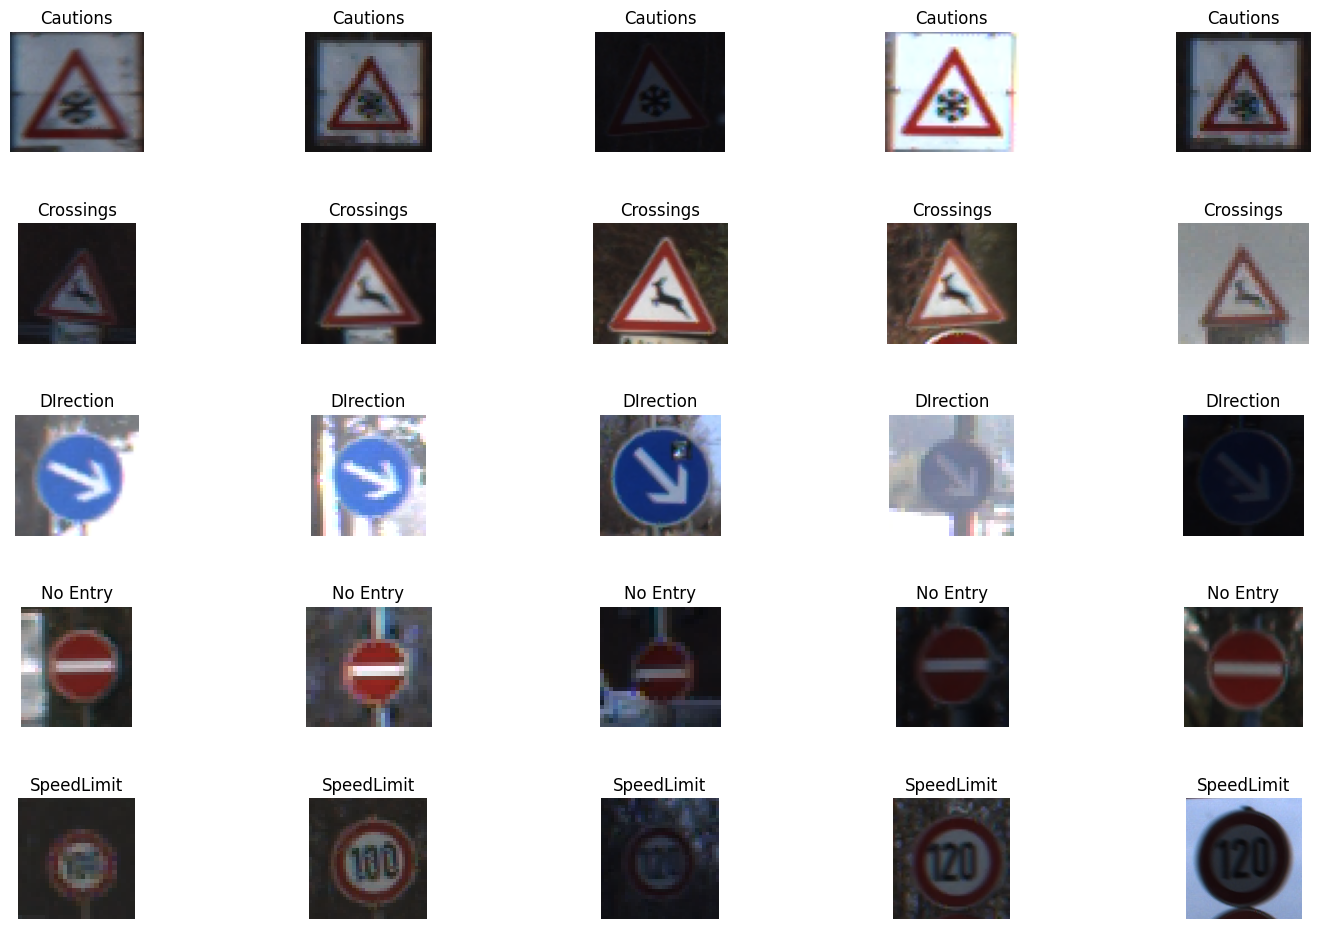

In [ ]:
import cv2


def load_images_from_folder(folder, count=5):
    """Load a limited number of images from a folder."""
    images = []
    for filename in os.listdir(folder):
        if len(images) == count:
            break
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            images.append(img)
    return images

# Path to training dataset
base_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train'

# List of class/category folder names
categories = ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']

# Create a grid of subplots: one row per category, 5 images each
fig, axs = plt.subplots(nrows=len(categories), ncols=5, figsize=(15, 10))
fig.tight_layout(pad=3.0)  # Add padding between plots

# Loop through each category and load/display images
for i, category in enumerate(categories):
    folder_path = os.path.join(base_path, category)
    images = load_images_from_folder(folder_path)

    for j in range(5):
        ax = axs[i, j]
        if j < len(images):
            # Convert BGR (OpenCV) to RGB for matplotlib
            img_rgb = cv2.cvtColor(images[j], cv2.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
        else:
            ax.set_facecolor('lightgrey')  # Gray box if not enough images

        ax.set_title(category)
        ax.axis('off')  # Hide axis ticks and labels

# Show all the images
plt.show()


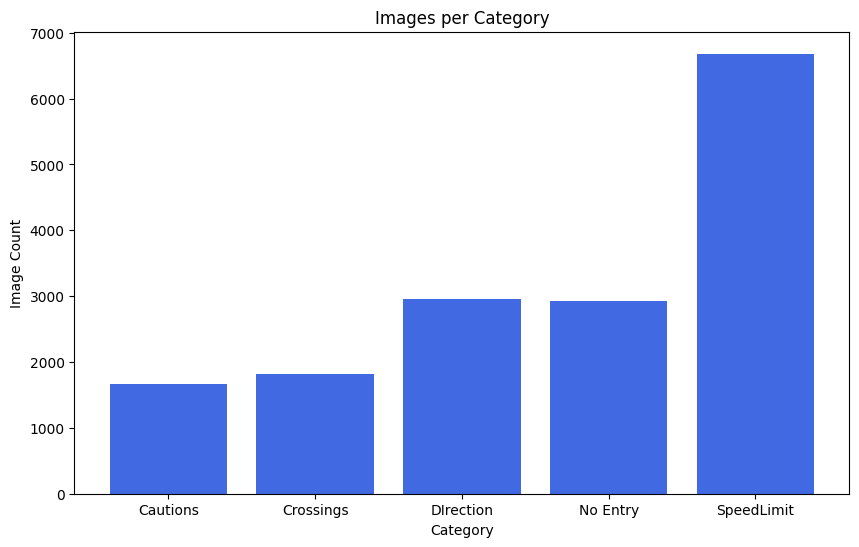

In [ ]:
# Count images in each category folder
image_counts = []
for category in categories:
    folder = os.path.join(base_path, category)
    count = len(os.listdir(folder))
    image_counts.append(count)

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, image_counts, color='royalblue')
plt.title('Images per Category')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.show()


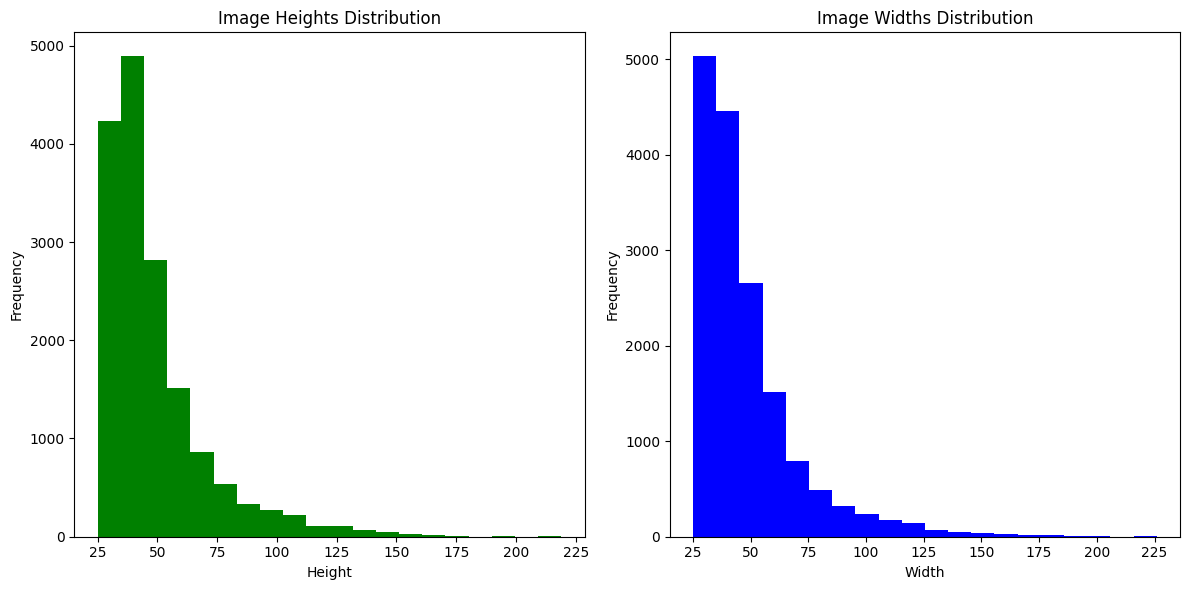

In [ ]:
#List to store image dimensions
image_sizes = []

#Loop through each category folder to gather image dimensions
for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        img_path = os.path.join(category_path, image_name)
        img = cv2.imread(img_path) #Read image
        if img is not None:
            image_sizes.append(img.shape[:2])  # Collect height and width
# Unpack list of dimensions into separate height and width
heights, widths = zip(*image_sizes)

# Plotting the distributions of image dimensions
plt.figure(figsize=(12, 6))

#Histogram for image heights
plt.subplot(1, 2, 1)
plt.hist(heights, bins=20, color='green')
plt.title('Image Heights Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

#Histogram for image widths
plt.subplot(1, 2, 2)
plt.hist(widths, bins=20, color='blue')
plt.title('Image Widths Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

#Improve layout and display
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Parameters for image processing and augmentation
batch_size = 32
img_height = 180
img_width = 180

# Setup augmentation configuration with ImageDataGenerator
augmentation_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to [0, 1]
    rotation_range=20,       # Rotate the images between 0 and 20 degrees
    width_shift_range=0.2,   # Shift the images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift the images vertically by up to 20% of the height
    shear_range=0.15,        # Shear the image by 15 degrees
    zoom_range=0.15,         # Zoom into the image by 15%
    horizontal_flip=True,    # Allow horizontal flipping
    fill_mode='nearest'      # Fill in new pixels with the nearest pixel values
)

# Assuming 'base_path' points to your training directory
base_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train'

# Create the generator to fetch images from the directory
train_augmented_generator = augmentation_datagen.flow_from_directory(
    base_path,             # Directory containing the training images
    target_size=(img_height, img_width),  # Resize images to 64x64
    batch_size=batch_size,         # Process images in batches of 32
    class_mode='categorical',  # Since you are handling multiple classes
    shuffle=True           # Shuffle the order of images
)




Found 16065 images belonging to 5 classes.


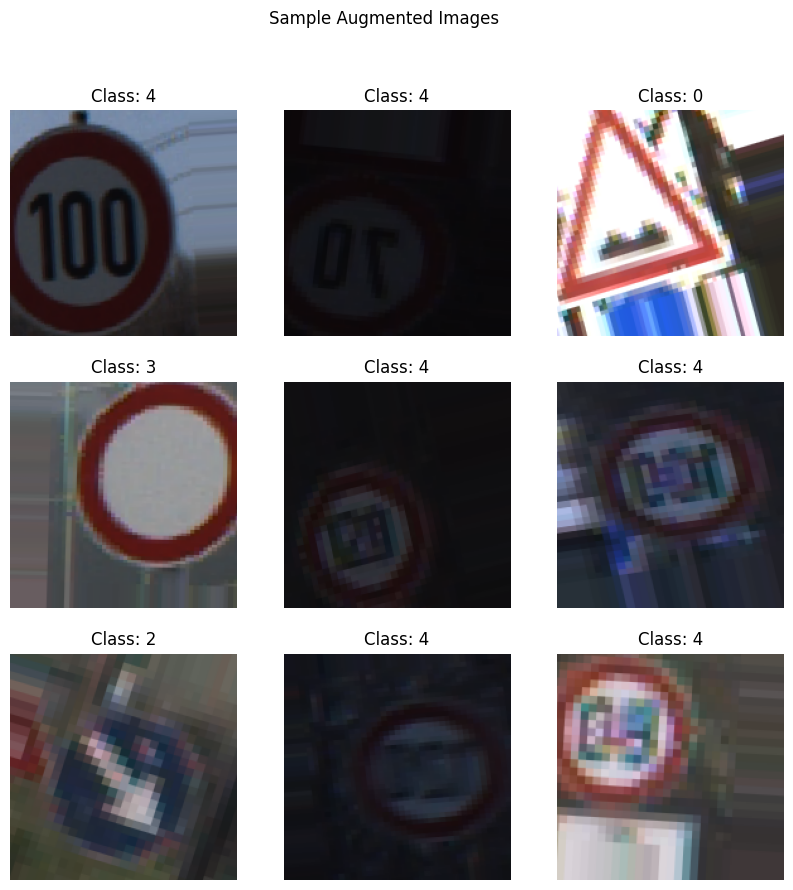

In [ ]:
# Fetch a batch of augmented images
augmented_images, labels = next(train_augmented_generator)

# Plotting the augmented images
plt.figure(figsize=(10, 10))

#loop through first 9 images in the batch
for i in range(9):
    ax = plt.subplot(3, 3, i + 1) # Create subplot for each image
    ax.imshow(augmented_images[i])# Display the image
    ax.axis("off") # Hide axis to focus images
    label = labels[i] # Get label for current image
    ax.set_title(f"Class: {label.argmax()}")  # Assuming 'argmax' since 'categorical'

#Add main title for the figure
plt.suptitle("Sample Augmented Images")

#show the plot
plt.show()


**FCNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# Adjusted ImageDataGenerators with validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values [0, 1]
    rotation_range=10,      # Rotate images randomly by 10 degrees
    width_shift_range=0.1,  #Shift images horizontally upto 10%
    height_shift_range=0.1, #Shift images vertically upto 10%
    shear_range=0.1,        # Apply random shear tranformation
    zoom_range=0.1,         #Zoom into images upto 10%
    horizontal_flip=True,   #Flip images horizontly
    fill_mode='nearest',    # Fill newly created pixels with nearest pixel value
    validation_split=0.3    # split 30% of data for validation
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,        #Normalize pixel values for validation
    validation_split=0.3   # Same split percentage as training data
)

# Now setup the generators
train_generator = train_datagen.flow_from_directory(
    base_path,            # Base directory containing the data
    target_size=(64, 64), # Resize images to 64x64
    batch_size=32,        # Number of images per batch
    class_mode='categorical', # Multi-class classificatio
    subset='training'  # Specify this is training data
)

# Setup the validation generator to load validation data from directory
validation_generator = validation_datagen.flow_from_directory(
    base_path, # Same base directory
    target_size=(64, 64), # Resize images
    batch_size=32, #Number of images per batch
    class_mode='categorical', # Multi-class classification
    subset='validation'  # Specify this is validation data
)


# Alternative way to create validation dataset using 'image_dataset_from_directory'
valid_ds = tf.keras.utils.image_dataset_from_directory(
base_path, # Base directory containing the data
validation_split=0.2, # Split 20% data for validation
subset="validation", # Specify the subset for data validation
seed=123, # Random seed for reproducibility
image_size=(img_height, img_width), # Resize images to specified size
batch_size=batch_size) # Number of images per batch


Found 11247 images belonging to 5 classes.
Found 4818 images belonging to 5 classes.
Found 16065 files belonging to 5 classes.
Using 3213 files for validation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model = Sequential([
    # 1st Convolution + Pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),  # 32 filters, 3x3 kernel
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd Convolution + Pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # 3rd Convolution + Pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten before FC layers
    Flatten(),

    # 1st FC layer
    Dense(512, activation='relu'),
    Dropout(0.3),

    # 2nd FC layer
    Dense(256, activation='relu'),
    Dropout(0.3),

    # 3rd FC layer
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer for 5 classes
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model structure
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,617,925 (9.99 MB)

 Trainable params: 2,617,925 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train model using training and validation generators
history = model.fit(
    train_generator, # Training data generator
    validation_data=validation_generator, # Validation data generator
    epochs=15,  # Number of training cycle
    verbose=1  # Ensure verbose is set to 1 (default) to get the output per epoch
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 79s 199ms/step - accuracy: 0.5920 - loss: 1.0493 - val_accuracy: 0.8514 - val_loss: 0.3988
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 73s 193ms/step - accuracy: 0.9003 - loss: 0.2233 - val_accuracy: 0.8433 - val_loss: 0.4658
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - accuracy: 0.9350 - loss: 0.1612 - val_accuracy: 0.7802 - val_loss: 1.1958
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - accuracy: 0.9533 - loss: 0.1122 - val_accuracy: 0.8499 - val_loss: 0.7551
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - accuracy: 0.9690 - loss: 0.0870 - val_accuracy: 0.8213 - val_loss: 1.2586
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.9795 - loss: 0.0578 - val_accuracy: 0.7839 - val_loss: 2.3090
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.9818 - loss: 0.0536 - val_accuracy: 0.8319 - val_loss: 1.1255
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 72s 166ms/step - accuracy: 0.9845 - loss: 0

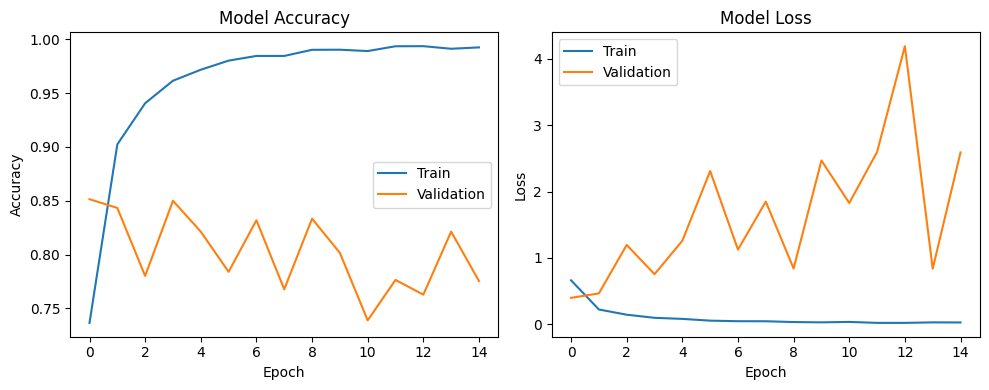

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 4))

#Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

#Show the plots
plt.tight_layout()
plt.show()


151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step
Classification Report:

              precision    recall  f1-score   support

    Cautions       0.07      0.03      0.04       501
   Crossings       0.12      0.22      0.16       546
   DIrection       0.19      0.17      0.18       888
    No Entry       0.19      0.07      0.10       879
  SpeedLimit       0.43      0.54      0.48      2004

    accuracy                           0.30      4818
   macro avg       0.20      0.20      0.19      4818
weighted avg       0.27      0.30      0.27      4818



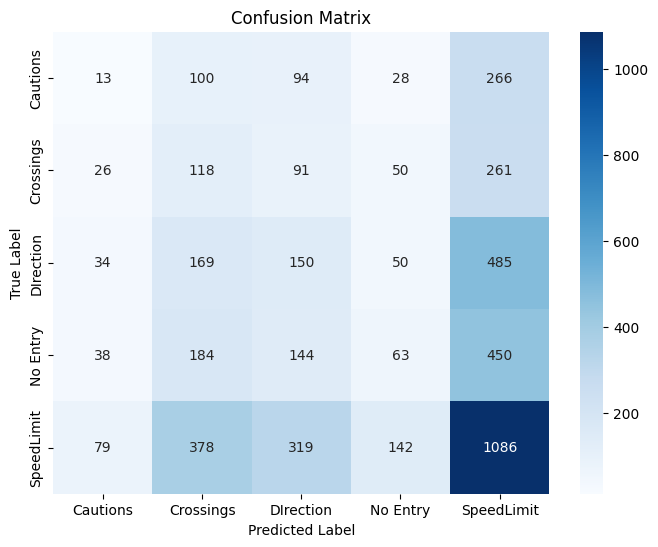

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import seaborn as sns
# Get predictions on validation set
validation_generator.reset()
preds = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = validation_generator.classes

# Class labels
class_labels = list(validation_generator.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf

# Load dataset from the specified directory and create batches of images
test_ds = tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train",  # Path to the image dataset
    seed=123,                          # Seed for shuffling
    image_size=(img_height, img_width),  # Resize images to target size
    batch_size=batch_size             # Set batch size
)

# Get and print the list of class names (folder names = class labels)
class_names = test_ds.class_names
print("Class names:", class_names)


Found 16065 files belonging to 5 classes.
Class names: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


In [ ]:
import tensorflow as tf
import os
import random

# === Define paths and parameters ===
train_directory = "/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train"
img_height = 64
img_width = 64
batch_size = 32
samples_per_class = 10  # Number of test images per class

# === Load dataset to get class names ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names from folder structure
class_names = train_ds.class_names
print("Class names:", class_names)
num_classes = len(class_names)

# === Function to load and preprocess an image ===
def load_and_preprocess_image(path, label):
    try:
        # Read and decode the image
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
        image.set_shape([None, None, 3])  # Allow flexible input shape

        # Resize and fix final shape
        image = tf.image.resize(image, [img_height, img_width])
        image.set_shape((img_height, img_width, 3))

        # One-hot encode the label
        label = tf.one_hot(label, num_classes)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        image = tf.zeros((img_height, img_width, 3))  # Placeholder image
        label = tf.one_hot(label, num_classes)

    return image, label

# === Sample 10 images per class ===
test_image_paths = []
test_labels = []

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_directory, class_name)
    image_list = os.listdir(class_path)

    # Randomly select N images from each class
    selected_images = random.sample(image_list, samples_per_class)
    test_image_paths.extend([os.path.join(class_path, img) for img in selected_images])
    test_labels.extend([class_idx] * samples_per_class)

# === Validate and filter images ===
valid_paths = []
valid_labels = []

for path, label in zip(test_image_paths, test_labels):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        if img.shape.rank == 3:  # Must be a valid image
            valid_paths.append(path)
            valid_labels.append(label)
    except Exception as e:
        print(f"Skipping {path}: {e}")

# === Create test dataset ===
test_ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# === Evaluate the model on the test dataset ===
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


Found 16065 files belonging to 5 classes.
Class names: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9525 - loss: 8.2457
Test Accuracy: 0.9600
Test Loss: 6.9437


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Assuming 'validation_generator' is already set up and the model is trained

# Make predictions with the model
predictions = model.predict(validation_generator)
true_labels = validation_generator.classes
predicted_labels = np.argmax(predictions, axis=1)

# Convert labels to categorical
true_labels_categorical = to_categorical(true_labels, num_classes=5)


151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
Image: 00008_00013_00018.png, Predicted Class: Speed Limit


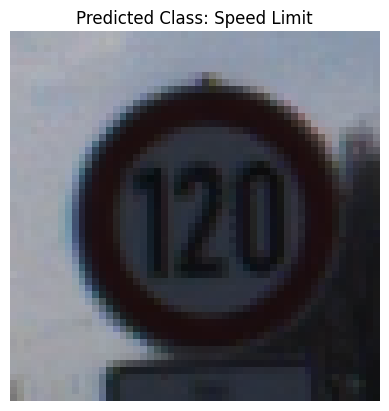

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Image: 00021_00000_00001.png, Predicted Class: Crossings


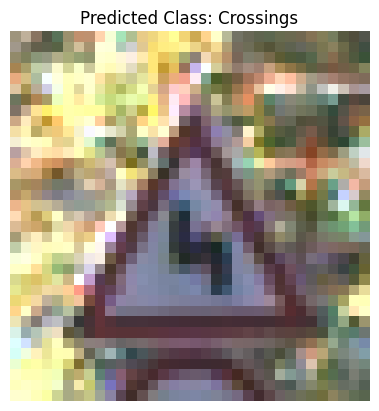

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: 00004_00002_00011.png, Predicted Class: Speed Limit


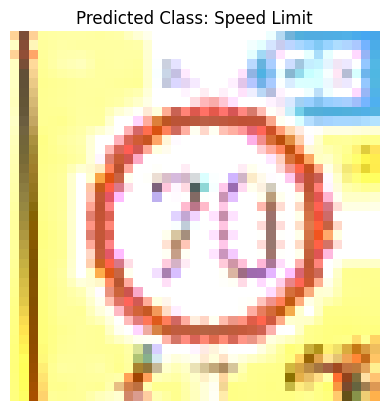

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: 00021_00000_00000.png, Predicted Class: Crossings


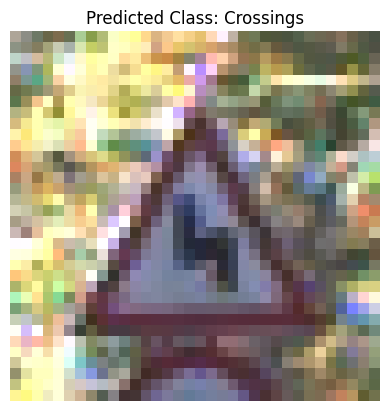

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: 00027_00000_00002.png, Predicted Class: Crossings


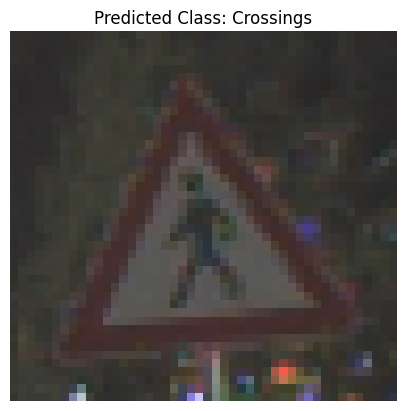

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: 00036_00000_00001.png, Predicted Class: Speed Limit


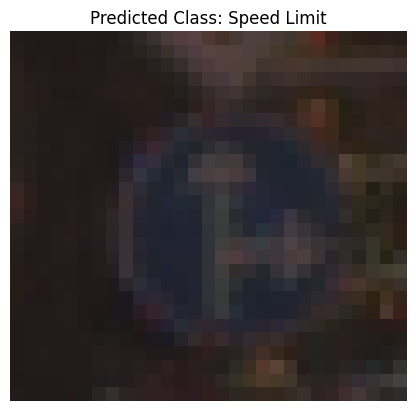

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: 00014_00000_00002.png, Predicted Class: Speed Limit


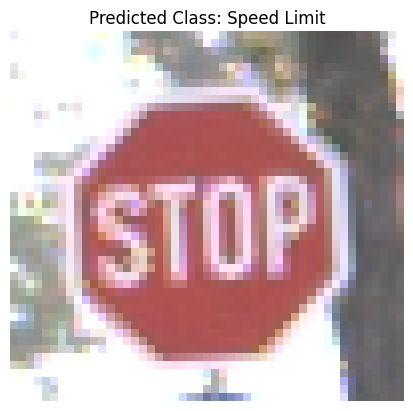

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Image: 00036_00000_00002.png, Predicted Class: Direction


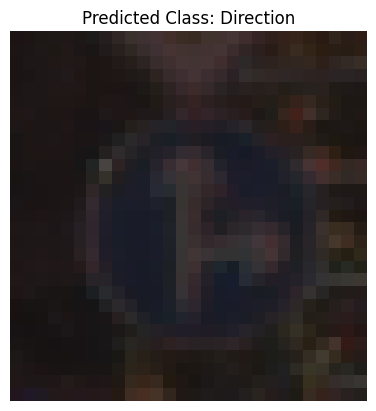

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: 00027_00000_00003.png, Predicted Class: Crossings


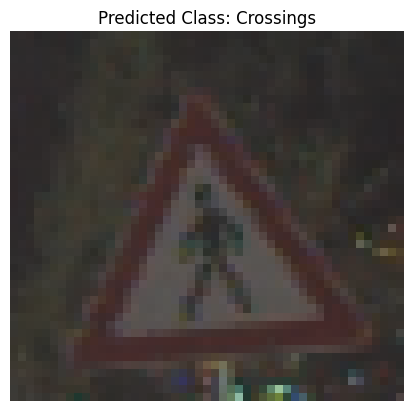

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: 00015_00002_00026.png, Predicted Class: NoEntry


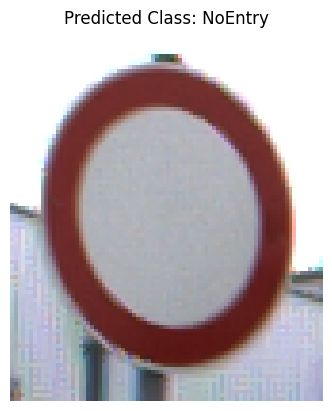

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

# === Function to preprocess a single image ===
def preprocess_image(image_path, target_size=(64, 64)):
    # Load image from path and resize to target size
    img = load_img(image_path, target_size=target_size)

    # Convert the PIL image to a NumPy array
    img = img_to_array(img)

    # Normalize pixel values (scale to 0-1)
    img = img / 255.0

    # Add batch dimension (model expects input shape like (1, 64, 64, 3))
    img = np.expand_dims(img, axis=0)

    return img

# === Directory path where test images are stored ===
test_dir_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Test'

# === Dictionary to map predicted class index to readable labels ===
class_labels = {
    0: 'Cautions',
    1: 'Crossings',
    2: 'Direction',
    3: 'NoEntry',
    4: 'Speed Limit'
}

# === Process each image file in the directory ===
for filename in os.listdir(test_dir_path):
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Process only image files
        image_path = os.path.join(test_dir_path, filename)

        # Preprocess the image for model prediction
        test_image = preprocess_image(image_path)

        # Predict class probabilities using the trained model
        predictions = model.predict(test_image)

        # Get the index of the class with highest predicted probability
        predicted_class_index = np.argmax(predictions, axis=1)[0]

        # Map the index to the corresponding class label
        predicted_class_label = class_labels[predicted_class_index]

        # === Output the prediction result ===
        print(f"Image: {filename}, Predicted Class: {predicted_class_label}")

        # === Optional: Display the image with the predicted class label ===
        img = cv2.imread(image_path)  # Read image using OpenCV (BGR format)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying in matplotlib

        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class_label}")
        plt.axis('off')  # Hide axes for clean image display
        plt.show()


**CNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Extended deeper CNN model
deep_model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # FC Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output
    Dense(5, activation='softmax')
])

# Compile the model
deep_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
deep_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 4,647,589 (17.73 MB)

 Trainable params: 4,647,141 (17.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model to this file
checkpoint_path = "best_deep_model.h5"

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,                # Stop if no improvement in 5 epochs
    restore_best_weights=True # Revert to best weights
)

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, checkpoint]

# Train the deeper model with callbacks
deep_history = deep_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Use more epochs; early stopping will halt if needed
    callbacks=callbacks
)


Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3633 - loss: 3.7724
Epoch 1: val_loss improved from inf to 2.07651, saving model to best_deep_model.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 84s 202ms/step - accuracy: 0.3637 - loss: 3.7696 - val_accuracy: 0.5710 - val_loss: 2.0765
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6591 - loss: 1.6630
Epoch 2: val_loss improved from 2.07651 to 1.08172, saving model to best_deep_model.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 69s 195ms/step - accuracy: 0.6591 - loss: 1.6625 - val_accuracy: 0.8140 - val_loss: 1.0817
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7804 - loss: 1.1337
Epoch 3: val_loss improved from 1.08172 to 0.84009, saving model to best_deep_model.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.7804 - loss: 1.1334 - val_accuracy: 0.8311 - val_loss: 0.8401
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8567 - loss: 0.7420
Epoch 4: val_loss improved from 0.84009 to 0.71538, saving model to best_deep_model.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 90s 195ms/step - accuracy: 0.8567 - loss: 0.7418 - val_accuracy: 0.8481 - val_loss: 0.7154
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8844 - loss: 0.6060
Epoch 5: val_loss did not improve from 0.71538
352/352 ━━━━━━━━━━━━━━━━━━━━ 75s 174ms/step - accuracy: 0.8844 - loss: 0.6060 - val_accuracy: 0.7395 - val_loss: 0.9176
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9061 - loss: 0.5028
Epoch 6: val_loss improved from 0.71538 to 0.64884, saving model to best_deep_model.h5


352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.9061 - loss: 0.5028 - val_accuracy: 0.7927 - val_loss: 0.6488
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9276 - loss: 0.4248
Epoch 7: val_loss did not improve from 0.64884
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - accuracy: 0.9276 - loss: 0.4248 - val_accuracy: 0.7709 - val_loss: 1.0140
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9448 - loss: 0.4101
Epoch 8: val_loss did not improve from 0.64884
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.9448 - loss: 0.4101 - val_accuracy: 0.8715 - val_loss: 0.7555
Epoch 9/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9637 - loss: 0.3645
Epoch 9: val_loss did not improve from 0.64884
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9637 - loss: 0.3645 - val_accuracy: 0.7597 - val_loss: 0.8366
Epoch 10/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9733 - loss: 0.3003
Epoch 10: val_loss did not

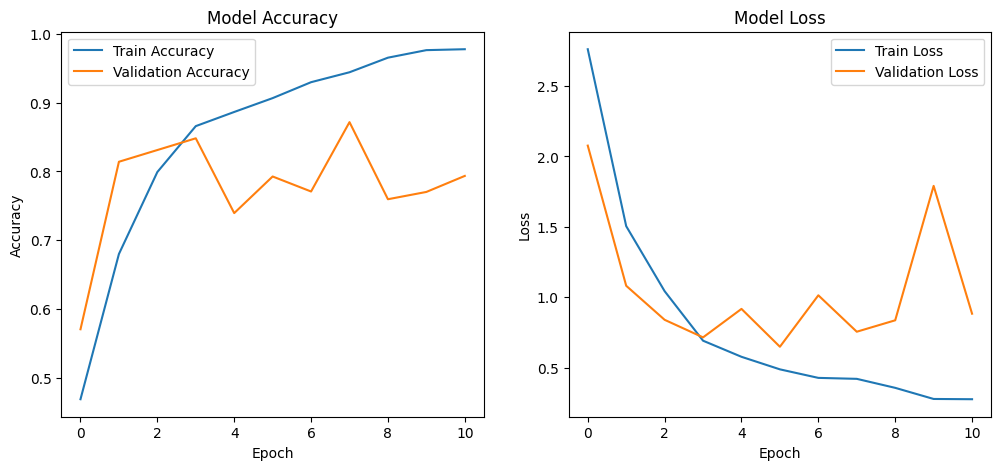

In [ ]:
# Import matplotlib for plotting the training history graphs
import matplotlib.pyplot as plt

# Create a figure with a size of 12x5 inches to hold both subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Plot training and validation accuracy values
plt.subplot(1, 2, 1)  # Create the first subplot (1 row, 2 columns, 1st subplot)
plt.plot(deep_history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(deep_history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Set the title of the first subplot
plt.ylabel('Accuracy')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(loc='upper left')  # Display the legend in the upper-left corner

# Subplot 2: Plot training and validation loss values
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, 2nd subplot)
plt.plot(deep_history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(deep_history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Set the title of the second subplot
plt.ylabel('Loss')  # Label for the y-axis
plt.xlabel('Epoch')  # Label for the x-axis
plt.legend(loc='upper right')  # Display the legend in the upper-right corner

# Display both subplots
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: 00008_00013_00018.png, Predicted Class: Speed Limit


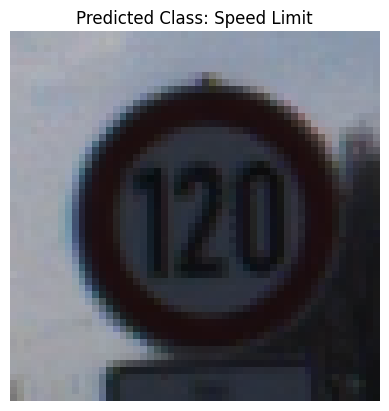

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Image: 00021_00000_00001.png, Predicted Class: Cautions


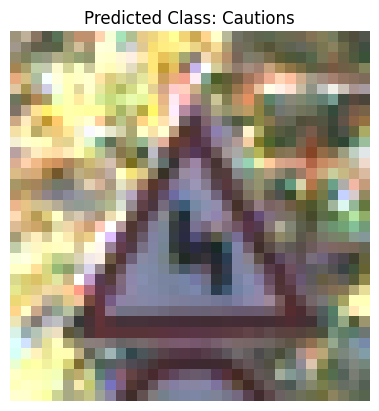

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: 00004_00002_00011.png, Predicted Class: Speed Limit


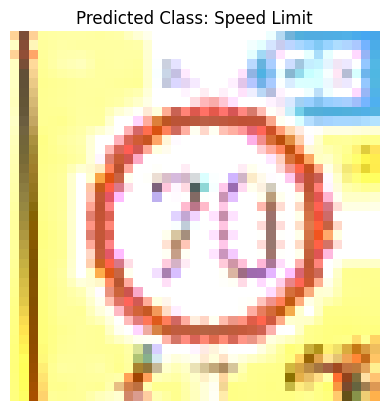

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: 00021_00000_00000.png, Predicted Class: Cautions


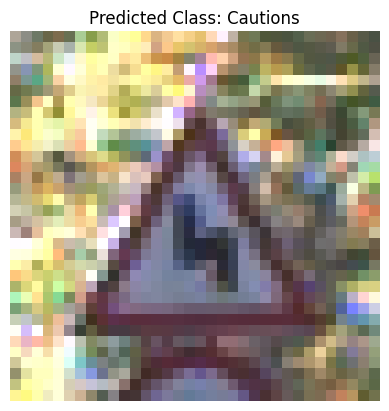

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 00027_00000_00002.png, Predicted Class: Crossings


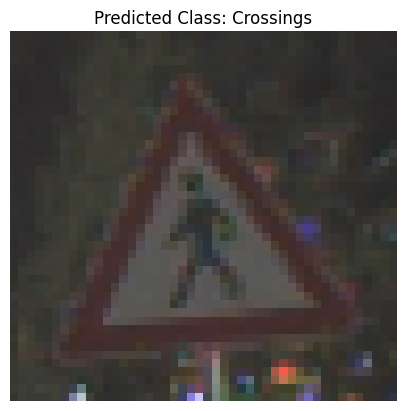

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 00036_00000_00001.png, Predicted Class: Direction


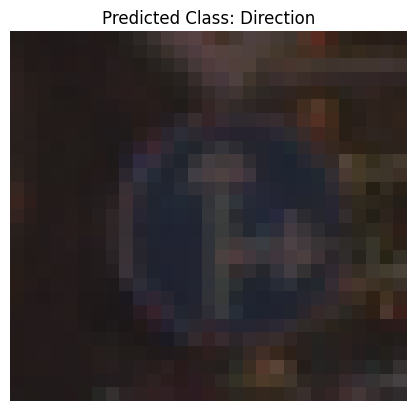

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image: 00014_00000_00002.png, Predicted Class: Speed Limit


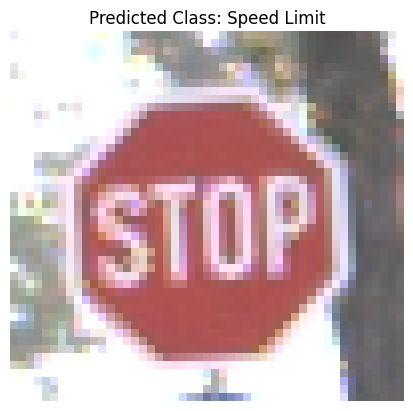

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 00036_00000_00002.png, Predicted Class: Direction


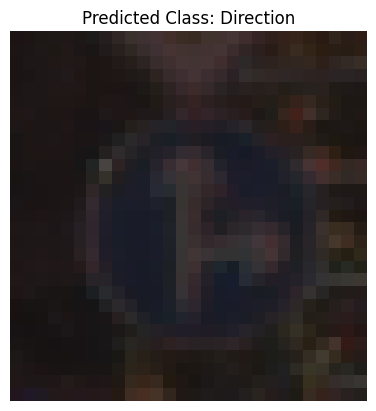

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: 00027_00000_00003.png, Predicted Class: Crossings


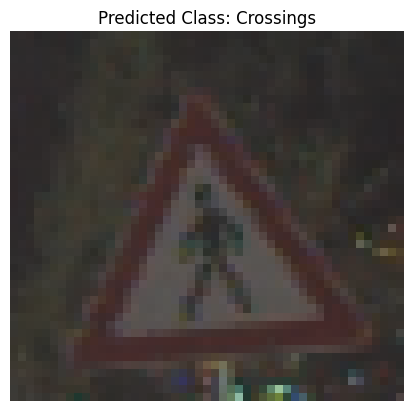

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Image: 00015_00002_00026.png, Predicted Class: NoEntry


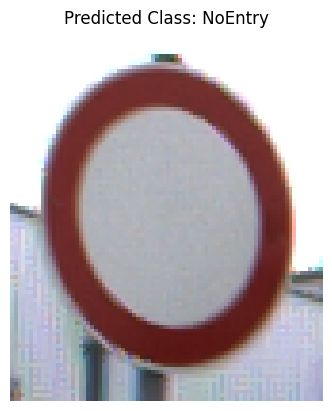

In [ ]:
def preprocess_image(image_path, target_size=(64, 64)):
    # Load image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to array
    img = img_to_array(img)
    # Scale the image
    img = img / 255.0
    # Expand dimensions to match the batch size
    img = np.expand_dims(img, axis=0)
    return img

# Provide the directory path containing images
test_dir_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Test'

# Dictionary mapping class indices to labels
class_labels = {0: 'Cautions', 1: 'Crossings', 2: 'Direction', 3: 'NoEntry', 4: 'Speed Limit'}

# Process each image in the directory
for filename in os.listdir(test_dir_path):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Check for image files
        image_path = os.path.join(test_dir_path, filename)
        test_image = preprocess_image(image_path)
        predictions = deep_model.predict(test_image)
        predicted_class_index = np.argmax(predictions, axis=1)
        predicted_class_label = class_labels[predicted_class_index[0]]

        # Output the result
        print(f"Image: {filename}, Predicted Class: {predicted_class_label}")

        # Display the image and prediction
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class_label}")
        plt.axis('off')
        plt.show()


In [ ]:
import tensorflow as tf
import os
import random

# Define the directory and parameters
train_directory = "/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train"
img_height = 64  # Set to match model's expected height
img_width = 64   # Set to match model's expected width
batch_size = 32   # Example batch size
num_samples_per_class = 10  # Number of images per class for the test set

# Load the full training dataset to get class names
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names and number of classes
class_names = train_ds.class_names
print("Class names:", class_names)
num_classes = len(class_names)

# Function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    try:
        image = tf.image.decode_image(image, channels=3)
        image.set_shape([None, None, 3])  # Allow dynamic shape for height and width
        image = tf.image.resize(image, [img_height, img_width])
        image.set_shape((img_height, img_width, 3))  # Ensure the final shape
        label = tf.one_hot(label, num_classes)  # One-hot encode the label
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        image = tf.zeros((img_height, img_width, 3))  # Use a placeholder in case of error
        label = tf.one_hot(label, num_classes)  # One-hot encode the placeholder label
    return image, label

# Sample 10 images per class
test_image_paths = []
test_labels = []

# Get a list of all images and their corresponding labels
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(train_directory, class_name)
    all_images = os.listdir(class_dir)
    selected_images = random.sample(all_images, num_samples_per_class)
    test_image_paths.extend([os.path.join(class_dir, img) for img in selected_images])
    test_labels.extend([class_index] * num_samples_per_class)

# Ensure all paths are valid and images are correctly loaded
valid_image_paths = []
valid_labels = []
for path, label in zip(test_image_paths, test_labels):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
        if image.shape.rank == 3:  # Ensure image is 3-dimensional
            valid_image_paths.append(path)
            valid_labels.append(label)
    except Exception as e:
        print(f"Skipping file {path} due to error: {e}")

# Create a TensorFlow dataset from the valid image paths and labels
test_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))
test_ds = test_ds.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size)

# Evaluate the model
loss, accuracy = deep_model.evaluate(test_ds)
print("Test Accuracy: ", accuracy)
print("Test loss: ", loss)


Found 16065 files belonging to 5 classes.
Class names: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6692 - loss: 26.8312
Test Accuracy:  0.6600000262260437
Test loss:  25.101455688476562


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 743ms/step
Classification Report:

              precision    recall  f1-score   support

    Cautions       0.40      1.00      0.57        10
   Crossings       0.00      0.00      0.00        10
   DIrection       0.91      1.00      0.95        10
    No Entry       1.00      0.70      0.82        10
  SpeedLimit       0.86      0.60      0.71        10

    accuracy                           0.66        50
   macro avg       0.63      0.66      0.61        50
weighted avg       0.63      0.66      0.61        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

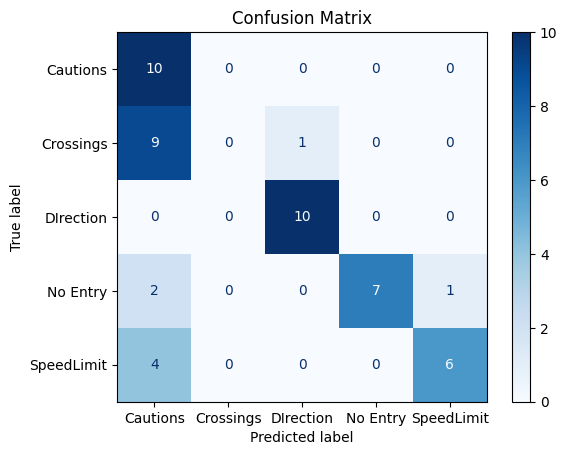

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to load and preprocess images (without one-hot encoding labels)
def load_and_preprocess_image_no_one_hot(path, label):
    image = tf.io.read_file(path)
    try:
        image = tf.image.decode_image(image, channels=3)
        image.set_shape([None, None, 3])  # Allow dynamic shape for height and width
        image = tf.image.resize(image, [img_height, img_width])
        image.set_shape((img_height, img_width, 3))  # Ensure the final shape
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        image = tf.zeros((img_height, img_width, 3))  # Use a placeholder in case of error
    return image, label

# Create a TensorFlow dataset from the valid image paths and labels
test_ds_no_one_hot = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))
test_ds_no_one_hot = test_ds_no_one_hot.map(lambda x, y: load_and_preprocess_image_no_one_hot(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_no_one_hot = test_ds_no_one_hot.batch(batch_size)

# Make predictions on the test dataset
predictions = deep_model.predict(test_ds_no_one_hot)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test dataset
true_labels = []
for _, label in test_ds_no_one_hot.unbatch():
    true_labels.append(label.numpy())

true_labels = np.array(true_labels)

from sklearn.metrics import classification_report

# Print the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n")
print(report)


# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


#SGD

In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=0.01, momentum=0.9)
deep_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
def create_deeper_model(input_shape, num_classes):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Create new instance of the model
deeper_model_sgd = create_deeper_model((img_width, img_height, 3), train_generator.num_classes)

# Compile with SGD
deeper_model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_sgd = deeper_model_sgd.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 76s 194ms/step - accuracy: 0.4015 - loss: 3.2671 - val_accuracy: 0.4014 - val_loss: 2.6435
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 172ms/step - accuracy: 0.6898 - loss: 1.9920 - val_accuracy: 0.7179 - val_loss: 1.8491
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.7971 - loss: 1.5124 - val_accuracy: 0.8512 - val_loss: 1.2964
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8449 - loss: 1.2661 - val_accuracy: 0.8445 - val_loss: 1.1677
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8847 - loss: 1.0700 - val_accuracy: 0.7227 - val_loss: 1.2863
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 90s 195ms/step - accuracy: 0.9138 - loss: 0.9340 - val_accuracy: 0.8041 - val_loss: 1.0493
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.9394 - loss: 0.8010 - val_accuracy: 0.7441 - val_loss: 1.0788
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - accuracy: 0.9526 - loss: 0

In [ ]:
print("Adam Optimizer - Best Validation Accuracy:", max(history.history['val_accuracy']))
print("SGD Optimizer  - Best Validation Accuracy:", max(history_sgd.history['val_accuracy']))

Adam Optimizer - Best Validation Accuracy: 0.8513906002044678
SGD Optimizer  - Best Validation Accuracy: 0.917600691318512


**VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the base VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()  # This will give us detailed layer outputs

# Check the output shape of the last layer
print("Output shape of the last layer:", base_model.output.shape)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Output shape of the last layer: (None, 7, 7, 512)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Load the base VGG16 model without the top layers and make sure to freeze the appropriate layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze the layers to not train them again

# Build custom top layers for the model
x = Flatten()(base_model.output)  # Flatten the outputs of the base model from (None, 7, 7, 512)
x = Dense(512, activation='relu')(x)  # First dense layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(5, activation='softmax')(x)  # Final dense layer with softmax for classification

# Complete model
VGG16model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
VGG16model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the setup
VGG16model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,821 (105.14 MB)

 Trainable params: 12,848,133 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

# Now setup the generators
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    base_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 11247 images belonging to 5 classes.
Found 4818 images belonging to 5 classes.


Found 12853 images belonging to 5 classes.
Found 3212 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - accuracy: 0.7287 - loss: 0.7194 - val_accuracy: 0.8565 - val_loss: 0.3336
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9354 - loss: 0.2242 - val_accuracy: 0.8780 - val_loss: 0.2855
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9521 - loss: 0.1529 - val_accuracy: 0.8876 - val_loss: 0.2850
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9742 - loss: 0.1019 - val_accuracy: 0.8910 - val_loss: 0.2949
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9742 - loss: 0.0947 - val_accuracy: 0.8945 - val_loss: 0.2612
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9823 - loss: 0.0755 - val_accuracy: 0.8966 - val_loss: 0.3077
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9839 - loss: 0.0638 - val_accuracy: 0.8839 - val_loss: 0.3368
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9850 - loss: 0.0613 - val_accu

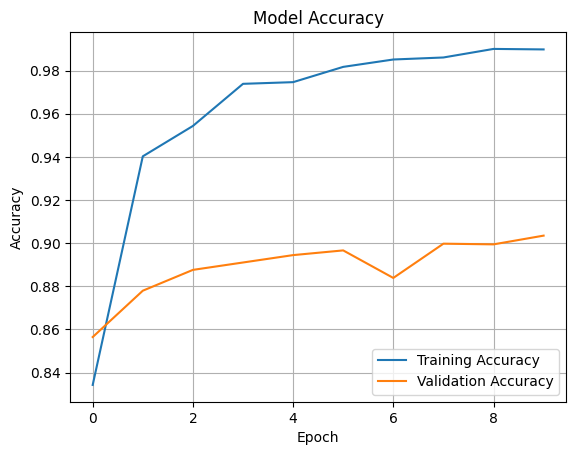

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # Change the number if you have a different number of classes

# Define the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Data directories
train_dir = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train'  # Make sure this path is correct

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

# Train the model
vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

# Optional: Plot training and validation accuracy
plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
vgg16_model.save('vgg16_traffic_sign_model.h5')


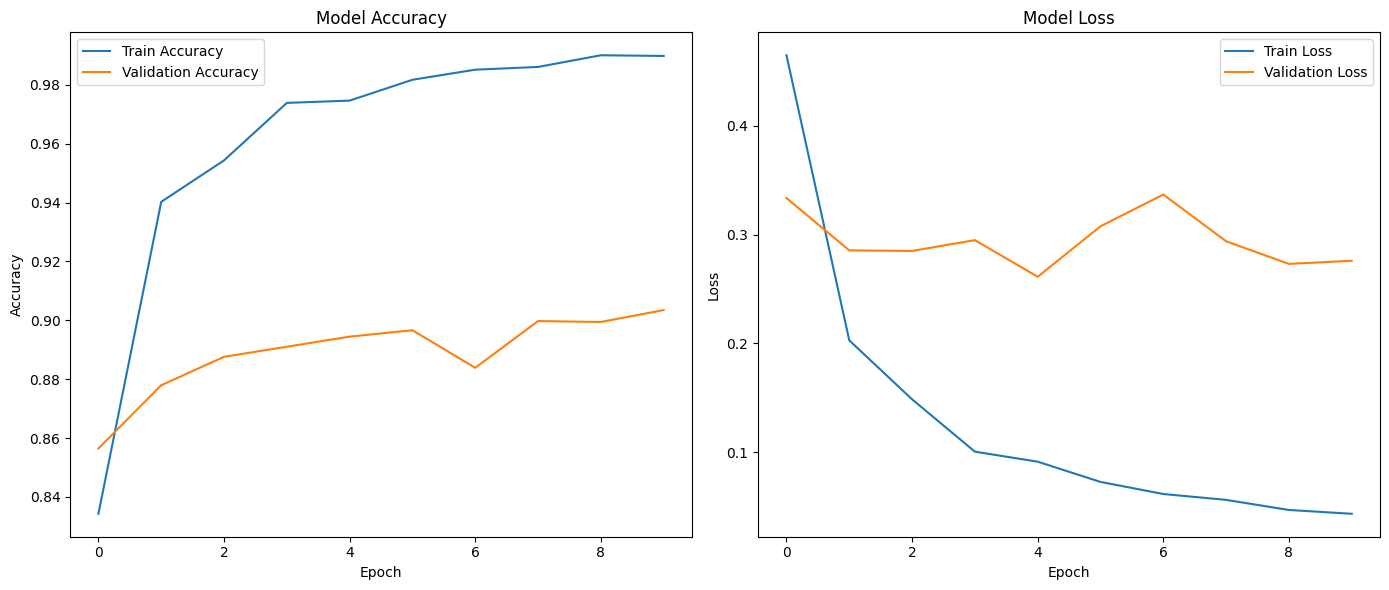

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image: 00008_00013_00018.png, Predicted Class: Speed Limit


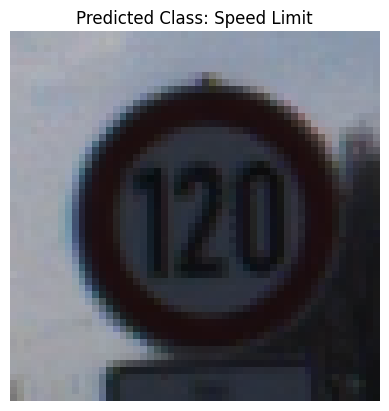

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image: 00021_00000_00001.png, Predicted Class: Crossings


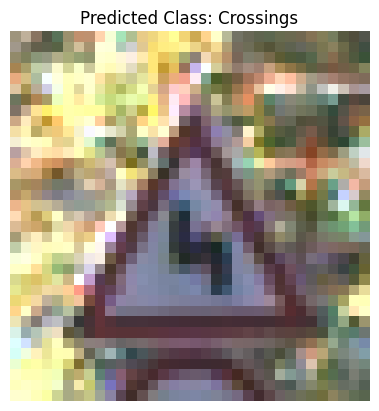

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: 00004_00002_00011.png, Predicted Class: Speed Limit


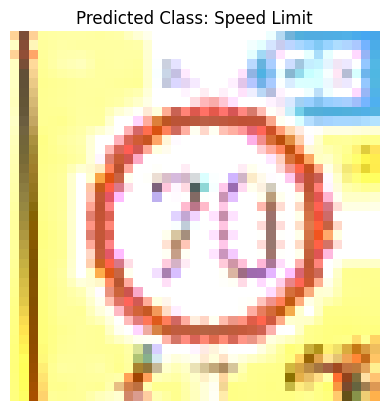

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: 00021_00000_00000.png, Predicted Class: Cautions


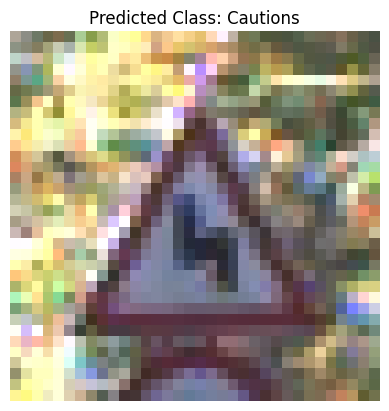

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: 00027_00000_00002.png, Predicted Class: Cautions


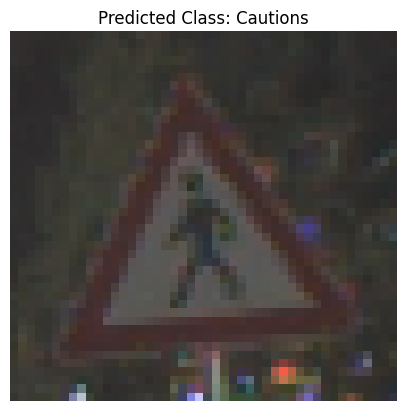

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Image: 00036_00000_00001.png, Predicted Class: Direction


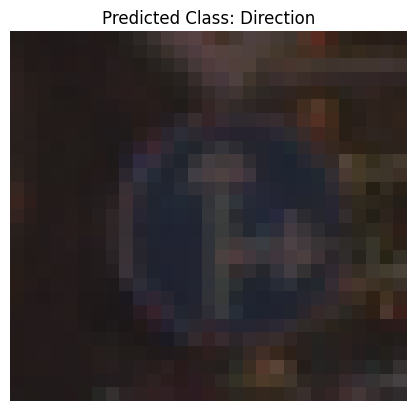

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: 00014_00000_00002.png, Predicted Class: NoEntry


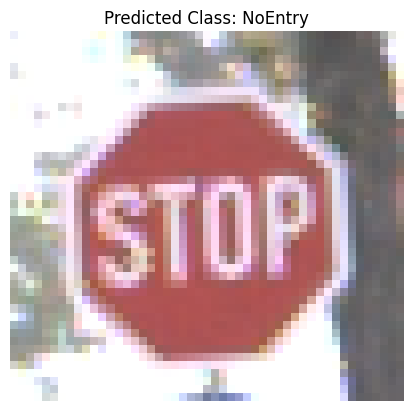

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Image: 00036_00000_00002.png, Predicted Class: Direction


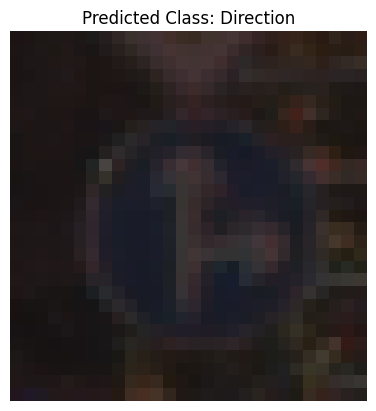

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: 00027_00000_00003.png, Predicted Class: Crossings


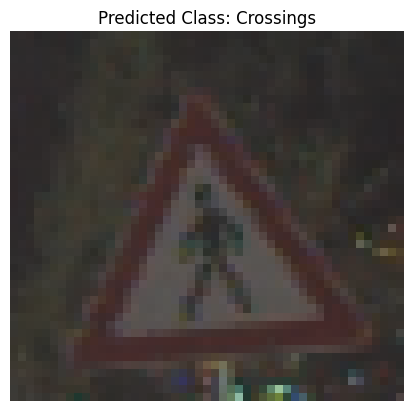

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: 00015_00002_00026.png, Predicted Class: NoEntry


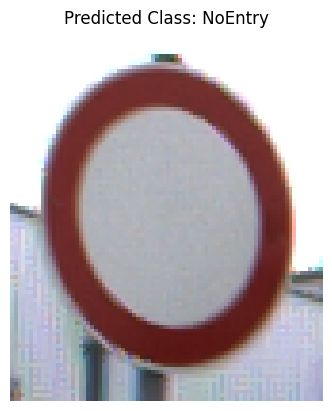

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model  # Only if your model isn't already in memory

# Assuming your VGG16 model is loaded and named 'model'
# If not, you might load it using load_model('path_to_your_model.h5')

def preprocess_image(image_path, target_size=(224, 224)):  # Update target_size for VGG16
    # Load image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to array
    img = img_to_array(img)
    # Scale the image
    img = img / 255.0
    # Expand dimensions to match the batch size
    img = np.expand_dims(img, axis=0)
    return img

# Provide the directory path containing images
test_dir_path = '/content/drive/MyDrive/AIML/Traffic_Sign_-2/Test'

# Dictionary mapping class indices to labels
class_labels = {0: 'Cautions', 1: 'Crossings', 2: 'Direction', 3: 'NoEntry', 4: 'Speed Limit'}

# Process each image in the directory
for filename in os.listdir(test_dir_path):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Check for image files
        image_path = os.path.join(test_dir_path, filename)
        test_image = preprocess_image(image_path)
        predictions = vgg16_model.predict(test_image)
        predicted_class_index = np.argmax(predictions, axis=1)
        predicted_class_label = class_labels[predicted_class_index[0]]

        # Output the result
        print(f"Image: {filename}, Predicted Class: {predicted_class_label}")

        # Display the image and prediction
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"Predicted Class: {predicted_class_label}")
        plt.axis('off')
        plt.show()


26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step


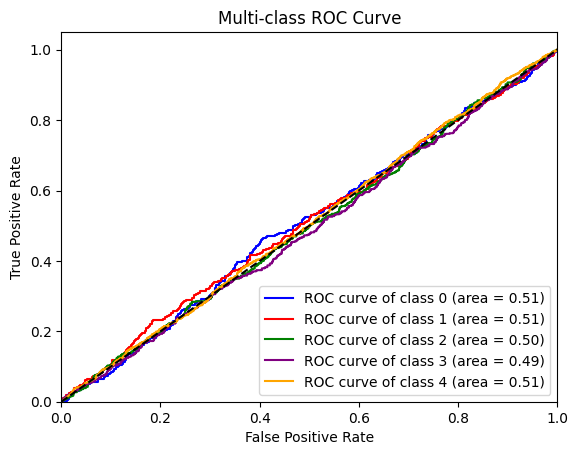

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
import numpy as np

# Get predictions and true labels
predictions = vgg16_model.predict(validation_generator)
true_labels = validation_generator.classes
n_classes = 5

# Binarize the true labels for multi-class ROC curve
true_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the directory and parameters
train_directory = "/content/drive/MyDrive/AIML/Traffic_Sign_-2/Train"
img_height = 224  # Set to match VGG16's expected height
img_width = 224   # Set to match VGG16's expected width
batch_size = 32   # Example batch size
num_samples_per_class = 10  # Number of images per class for the test set

# Load the full training dataset to get class names
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names and number of classes
class_names = train_ds.class_names
print("Class names:", class_names)
num_classes = len(class_names)

# Function to load and preprocess images
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    try:
        image = tf.image.decode_image(image, channels=3)
        image.set_shape([None, None, 3])  # Allow dynamic shape for height and width
        image = tf.image.resize(image, [img_height, img_width])
        image.set_shape((img_height, img_width, 3))  # Ensure the final shape
        label = tf.one_hot(label, num_classes)  # One-hot encode the label
    except Exception as e:
        print(f"Error processing file {path}: {e}")
        image = tf.zeros((img_height, img_width, 3))  # Use a placeholder in case of error
        label = tf.one_hot(label, num_classes)  # One-hot encode the placeholder label
    return image, label

# Sample 10 images per class
test_image_paths = []
test_labels = []

# Get a list of all images and their corresponding labels
for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(train_directory, class_name)
    all_images = os.listdir(class_dir)
    selected_images = random.sample(all_images, num_samples_per_class)
    test_image_paths.extend([os.path.join(class_dir, img) for img in selected_images])
    test_labels.extend([class_index] * num_samples_per_class)

# Ensure all paths are valid and images are correctly loaded
valid_image_paths = []
valid_labels = []
for path, label in zip(test_image_paths, test_labels):
    try:
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
        if image.shape.rank == 3:  # Ensure image is 3-dimensional
            valid_image_paths.append(path)
            valid_labels.append(label)
    except Exception as e:
        print(f"Skipping file {path} due to error: {e}")

# Create a TensorFlow dataset from the valid image paths and labels
test_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))
test_ds = test_ds.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size)

# Evaluate the model
loss, accuracy = vgg16_model.evaluate(test_ds)
print("Test Accuracy: ", accuracy)
print("Test loss: ", loss)




Found 16065 files belonging to 5 classes.
Class names: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.8679 - loss: 6.7778
Test Accuracy:  0.8799999952316284
Test loss:  6.140517711639404


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step


<Figure size 1000x800 with 0 Axes>

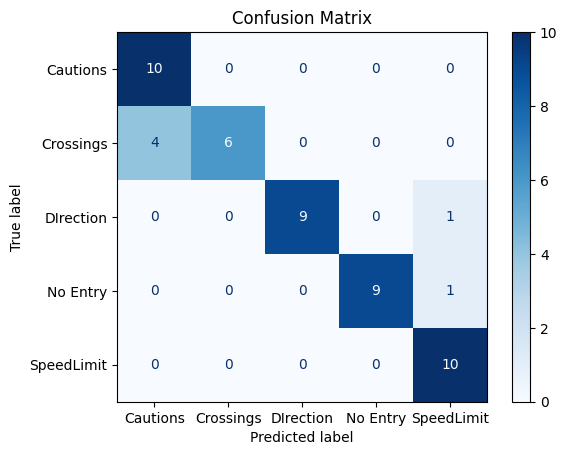

In [ ]:
# Make predictions on the test dataset
predictions = vgg16_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test dataset
true_labels = []
for _, label in test_ds.unbatch():
    true_labels.append(np.argmax(label.numpy()))

true_labels = np.array(true_labels)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()